# EX03 캐글 집값예측 모델 만들기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(os.getcwd())
data_dir="/content/drive/MyDrive/EX03_data/"#폴더경로

/content


# 1. 데이터셋 불러오기

In [4]:
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 2. feature engineering

In [6]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) #date column 축약하기
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
train_y = train['price']#학습데이터 target value
del train['price']
del train['id']

In [8]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

<Axes: xlabel='price', ylabel='Density'>

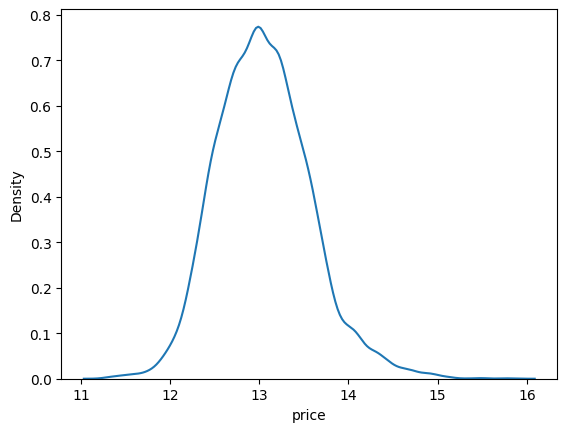

In [9]:
train_y = np.log1p(train_y) # logscale로 변환
sns.kdeplot(train_y) #target y 밀도 확인

# 3. 데이터 분리 및 모델 생성

In [10]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error

In [11]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2020   

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

# 4.모델별 하이퍼 파라미터 추정

In [15]:
from sklearn.model_selection import GridSearchCV

gboost_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [50, 100],
    'max_depth': [3, 10],
}

xgboost_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [50, 100],
    'max_depth': [3, 10],
}

lightgbm_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [50, 100],
    'max_depth': [3, 10],
}

rdforest_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 10],
}

model_param=[gboost_param_grid, xgboost_param_grid, lightgbm_param_grid, rdforest_param_grid]
grid_models=[]
for i in range(len(models)):
  grid_model = GridSearchCV(models[i], param_grid=model_param[i], \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

  grid_model.fit(train, train_y)
  grid_models.append(grid_model)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


# 5. 각각 최적의 파라미터 출력해보기

In [21]:
def grid_hp(model):
  p=model.cv_results_['params']
  s=model.cv_results_['mean_test_score']
  results = pd.DataFrame(p)
  results['score'] = s
  results['RMSLE'] = np.sqrt(-1 * results['score'])
  results = results.sort_values('RMSLE')
  return results

In [25]:
print("{0}".format(models[0]))
grid_hp(grid_models[0]).head() #gboost 

GradientBoostingRegressor(random_state=2020)


,learning_rate,max_depth,n_estimators,score,RMSLE
3,0.10,10,100,-0.029483,0.171707
7,0.05,10,100,-0.029792,0.172604
2,0.10,10,50,-0.029899,0.172913
6,0.05,10,50,-0.033155,0.182084
1,0.10,3,100,-0.033394,0.182741


In [27]:
print("{0}".format(models[1]))
grid_hp(grid_models[1]).head() #xgboost 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2020, ...)


,learning_rate,max_depth,n_estimators,score,RMSLE
3,0.10,10,100,-0.027109,0.164650
1,0.10,3,100,-0.033881,0.184069
2,0.10,10,50,-0.033910,0.184145
7,0.05,10,100,-0.035356,0.188031
0,0.10,3,50,-0.044892,0.211877


In [28]:
print("{0}".format(models[2]))
grid_hp(grid_models[2]).head() #lightgbm

LGBMRegressor(random_state=2020)


,learning_rate,max_depth,n_estimators,score,RMSLE
3,0.10,10,100,-0.027027,0.164399
2,0.10,10,50,-0.029177,0.170814
7,0.05,10,100,-0.029227,0.170960
1,0.10,3,100,-0.033333,0.182573
6,0.05,10,50,-0.037337,0.193227


In [29]:
print("{0}".format(models[3]))
grid_hp(grid_models[3]).head() #rdforest

RandomForestRegressor(random_state=2020)


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.035232,0.187702
2,10,50,-0.035439,0.188252
1,3,100,-0.085454,0.292325
0,3,50,-0.085716,0.292773


# 5.모델 재생성 및 학습 후 4가지 모델에 대한 Averaging

In [30]:
gboost = GradientBoostingRegressor(learning_rate=0.1,max_depth=10, n_estimators=100, random_state=random_state)
xgboost = XGBRegressor(learning_rate=0.1,max_depth=10, n_estimators=100, random_state=random_state)
lightgbm = LGBMRegressor(learning_rate=0.1,max_depth=10, n_estimators=100, random_state=random_state)
rdforest = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [31]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [39]:
df={}
complete_models=[]
for model in models:
    model_name = model.__class__.__name__
    
    # train, test 데이터셋 분리
    x_train, x_test, y_train, y_test = train_test_split(train, train_y, test_size=0.2, random_state=42)
    # 모델 학습
    model.fit(x_train,y_train)
    # 예측
    pred=model.predict(x_train)
    df[model_name]= rmse(y_train,pred)
    complete_models.append(model)

#AveragingBlending
del test['id']
predictions = np.column_stack([
   np.expm1(m.predict(test)) for m in complete_models])
prediction=np.mean(predictions, axis=1)

print("각 모델별 rmse value")
df

각 모델별 rmse value


{'GradientBoostingRegressor': 23941.271047285667,
 'XGBRegressor': 45130.18338605402,
 'LGBMRegressor': 91502.56796567382,
 'RandomForestRegressor': 96073.78413740708}

결과 추출

In [40]:
#sub_id=test['id']
#del test['id']
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [41]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.016050e+05
1,15036,4.652336e+05
2,15037,1.340962e+06
3,15038,3.030156e+05
4,15039,3.287199e+05


In [43]:
#4개 모델에 대한 평균 점수 출력
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, '4models', '0.16')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)
#점수 11만7천점

/content/drive/MyDrive/EX03_data//submission_4models_RMSLE_0.16.csv


In [44]:
#임의로 정한 한 개의 모델에 대한 점수 출력
prediction=np.expm1(complete_models[0].predict(test))
submission['price'] = prediction
submission.head()
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'GBR', '0.17')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)
#점수 12만5천점

/content/drive/MyDrive/EX03_data//submission_GBR_RMSLE_0.17.csv
